# Data loading

In [1]:
import os
import requests
from pathlib import Path

## Data that is loaded is netflix stock prices from may 2002 to today

In [2]:
NFLX_path = Path("./data/NFLX.csv")

if not os.path.exists(NFLX_path):
    os.mkdir(Path('./data'))
    req = requests.get('https://query1.finance.yahoo.com/v7/finance/download/NFLX?period1=1022198400&period2=1717686622&interval=1d&events=history&includeAdjustedClose=true', headers = {'User-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/125.0.0.0 Safari/537.3'})
    if req.status_code == 200:
        with open(NFLX_path, 'wb') as f:
            f.write(req.content)
        print('Data file loaded.')
    else:
        raise AssertionError('CSV file not downloaded.', req.status_code)

# Data exploration

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [4]:
df = pd.read_csv(NFLX_path, parse_dates=['Date'])
df = df.sort_values('Date').set_index('Date')
df = df.drop_duplicates()
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200
2002-05-31,1.078571,1.078571,1.071429,1.076429,1.076429,8464400


<Axes: xlabel='Date'>

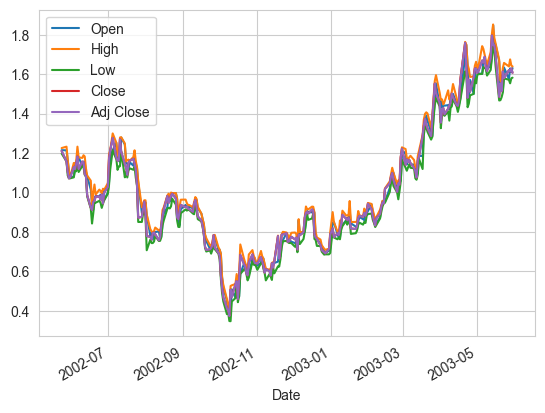

In [5]:
df['2002-05':'2003-05'].drop('Volume', axis=1).plot()

<Axes: xlabel='Date'>

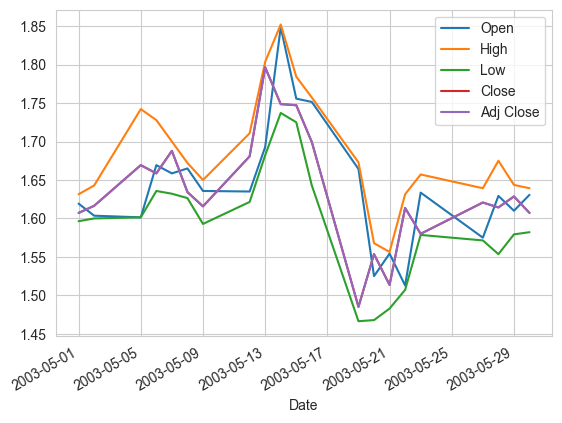

In [6]:
df['2003-05':'2003-05'].drop('Volume', axis=1).plot()

In [7]:
any_null_values =df.isnull().values.any()
any_nan_values = df.isna().values.any()

print("any_null_values:", any_null_values)
print("any_nan_values:", any_nan_values)

any_null_values: False
any_nan_values: False


<Axes: >

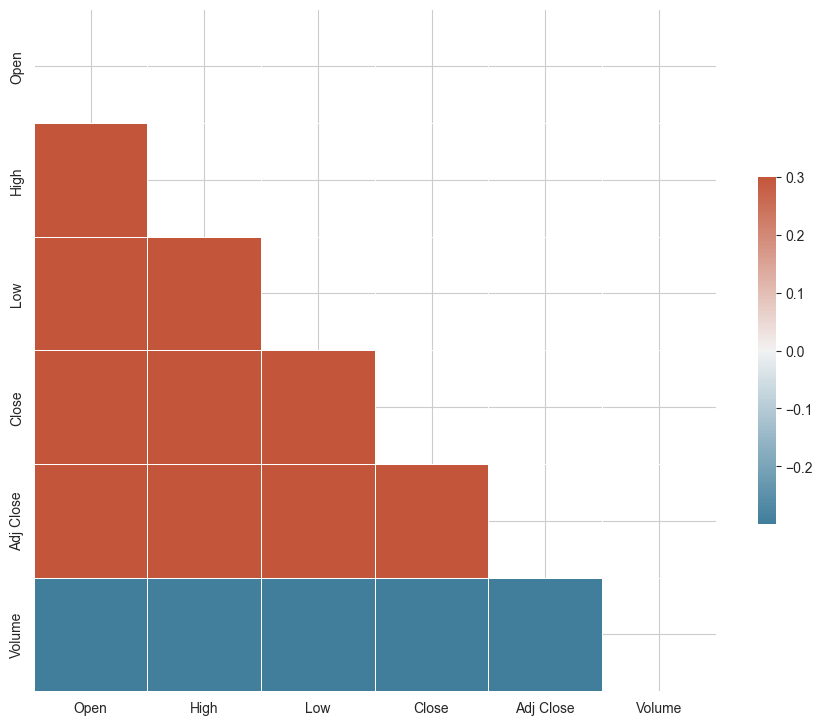

In [8]:
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Data split and scaling

In [9]:
from datetime import date
from datetime import timedelta


start_day = df.index.min().date()
today = date.today()

days_start_today = today-start_day

train_set_size = (days_start_today * 0.75)
validation_set_size = (days_start_today * 0.05)
test_set_size = days_start_today * 0.20

train_set_start_day = start_day
train_set_end_date = start_day + train_set_size - timedelta(1)

validation_set_start_date = train_set_end_date + timedelta(1)
validation_set_end_day = validation_set_start_date + validation_set_size - timedelta(1)

test_set_start_date = validation_set_end_day + timedelta(1)
test_set_end_day = today

print('train_set_start_day:', train_set_start_day,'\t' , 'train_set_end_date:', train_set_end_date)
print('validation_set_start_date:', validation_set_start_date, '\t' , 'validation_set_end_day:', validation_set_end_day)
print('test_set_start_date:', test_set_start_date, '\t' , 'test_set_end_day:', test_set_end_day)

train_set_start_day: 2002-05-24 	 train_set_end_date: 2018-12-02
validation_set_start_date: 2018-12-03 	 validation_set_end_day: 2020-01-08
test_set_start_date: 2020-01-09 	 test_set_end_day: 2024-06-07


In [10]:
train = df[train_set_start_day:train_set_end_date]
valid = df[validation_set_start_date:validation_set_end_day]
test = df[test_set_start_date:test_set_end_day]

In [11]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

std = StandardScaler()
train_scaled = pd.DataFrame(std.fit_transform(train), columns=df.columns)
valid_scaled = pd.DataFrame(std.transform(valid),columns=df.columns)
test_scaled = pd.DataFrame(std.transform(test),columns=df.columns)

seq_length = 56

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    train_scaled.to_numpy(),  # use all 5 columns as input
    targets=train_scaled[["High", "Low"]][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    valid_scaled.to_numpy(),
    targets=valid_scaled[["High", "Low"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True
)

test_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    test_scaled.to_numpy(),
    targets=test_scaled[["High", "Low"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True
)

# Model creation and teaching

In [12]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return (valid_mae * std.scale_ + std.mean_)[1:3]

In [13]:

mulvar_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=[None, 6]),
    tf.keras.layers.Dense(2)
])

valid_mae = fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

Epoch 1/500


C:\Users\kryst\.virtualenvs\dataScience\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0422 - mae: 0.1468 - val_loss: 0.0257 - val_mae: 0.1914
Epoch 2/500
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - mae: 0.0336 - val_loss: 0.0057 - val_mae: 0.0807
Epoch 3/500
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010 - mae: 0.0226 - val_loss: 0.0063 - val_mae: 0.0891
Epoch 4/500
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.9896e-04 - mae: 0.0218 - val_loss: 0.0057 - val_mae: 0.0836
Epoch 5/500
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.1408e-04 - mae: 0.0234 - val_loss: 0.0091 - val_mae: 0.1147
Epoch 6/500
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.5818e-04 - mae: 0.0214 - val_loss: 0.0073 - val_mae: 0.1003
Epoch 7/500
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.6282e-04 - mae: 0.0238 - val_loss: 0.0057 - val_mae: 0.0804
Epoch 8/500
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.9731e-04 - mae: 0.0187 - val_loss: 0.0060 - val_mae: 0.0893
Epoch 9/500
129/129 ━━━━━━━━━━━━━━━━━━

In [14]:
pd.DataFrame(valid_mae.reshape(-1,2), columns=['High MAE valid', 'Low MAE valid'])

,High MAE valid,Low MAE valid
0,55.151028,53.382921


In [15]:
test_loss, test_mae= mulvar_model.evaluate(test_mulvar_ds)
test_mae = (test_mae * std.scale_ + std.mean_)[1:3]
pd.DataFrame(test_mae.reshape(-1,2), columns=['High MAE test', 'Low MAE test'])

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1575 - mae: 0.3798


,High MAE test,Low MAE test
0,85.032283,82.298881


In [18]:
if not os.path.exists('./model'):
    os.mkdir(Path('./model'))
mulvar_model.save(Path('./model/netflix_model.keras'))